# Volley (or racketball or beach-volley) simulation

Simulate max_games volley matches played by 'a' vs 'b' where 'a' as a probability 'prob' between 0 and 1 of winning a point. Games are played until a team wins 'sets_to_win' sets. A set is won when a team scores
more or equal 'points_to_win' points with a difference of at least 2 points from the other team score

In [20]:
import random
import pandas as pd

def simulate_volley(a_win_prob=0.52, max_games=1000, sets_to_win=2, points_to_win_standard=21, points_to_win_last=15):
    a_wins = b_wins = a_tot_points = b_tot_points = a_tot_sets = b_tot_sets = 0
    rows = []

    while a_wins + b_wins < max_games:
        a_sets = b_sets = 0

        while a_sets < sets_to_win and b_sets < sets_to_win:
            a_points = b_points = 0
            points_to_win = points_to_win_standard if a_sets + b_sets < 2 * sets_to_win - 1 else points_to_win_last

            while not (a_points >= points_to_win and a_points - b_points >= 2) and not (b_points >= points_to_win and b_points - a_points >= 2):
                flag = 1
                a_win_point = random.random() < a_win_prob
                if a_win_point:
                    a_points += 1; a_tot_points += 1
                if not a_win_point:
                    b_points += 1; b_tot_points += 1

                if a_points >= points_to_win and a_points - b_points >= 2:
                    a_sets += 1; a_tot_sets += 1; flag = 2
                if b_points >= points_to_win and b_points - a_points >= 2:
                    b_sets += 1; b_tot_sets += 1; flag = 2

                if a_sets == sets_to_win:
                    a_wins += 1; flag = 3
                if b_sets == sets_to_win:
                    b_wins += 1; flag = 3

                rows.append({'F': flag, 'P': int(a_win_point), 'AS': a_sets, 'BS': b_sets, 'AP': a_points, 'BP': b_points,  'AW': a_wins, 'BW': b_wins, 'ATS': a_tot_sets, 'BTS': b_tot_sets, 'ATP': a_tot_points, 'BTP': b_tot_points})

    return rows

## Test
Change the probability and check that it makes sense ...

          WP        SP       PP
93065  0.615  0.575239  0.51485


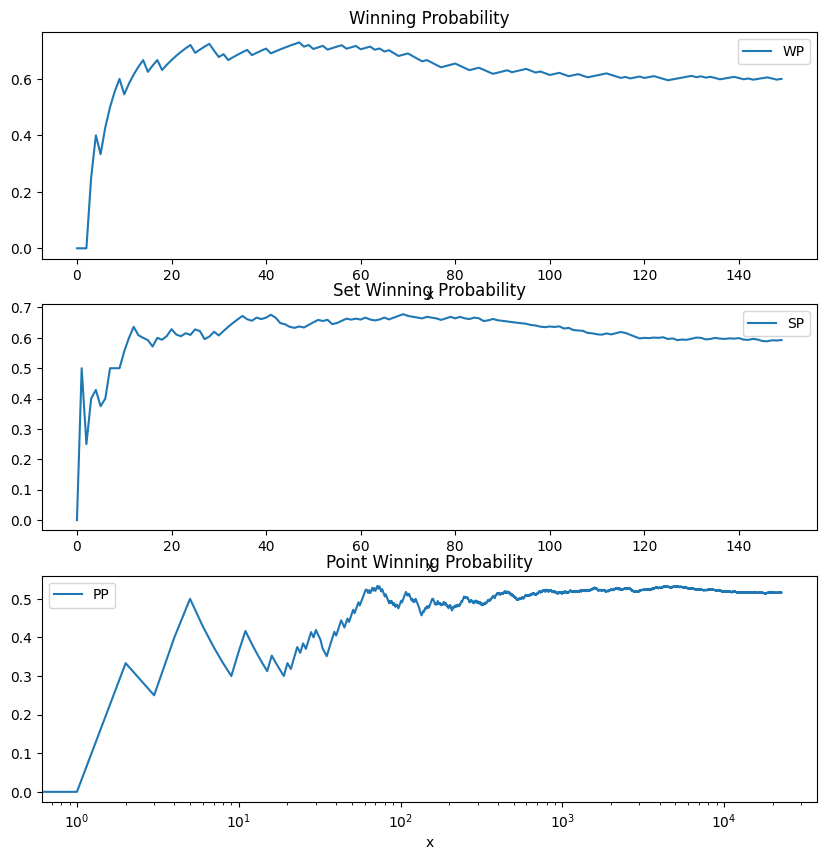

In [23]:
rows = simulate_volley(0.52)

df = pd.DataFrame(rows, columns=['F', 'P', 'AS', 'BS', 'AP', 'BP', 'AW', 'BW', 'ATS', 'BTS','ATP', 'BTP'])
df['WP'] = df['AW'] / (df['AW'] + df['BW'])
df['SP'] = df['ATS'] / (df['ATS'] + df['BTS'])
df['PP'] = df['ATP'] / (df['ATP'] + df['BTP'])

# Avoids SettingWithCopyWarning
pd.options.mode.copy_on_write = True

# Create a dataset containing just rows where Flag is 2
dfp = df[df['F'] == 1]
dfs = df[df['F'] == 2]
dfw = df[df['F'] == 3]

# Plot first N, N1 rows
N = 150
N1 = int(len(dfp['PP']) / 4)
dfw = dfw.head(N)
dfs = dfs.head(N)
dfp = dfp.head(N1)

# Create an increasing integer sequence for x-values
dfw['x'] = range(0, N)
dfs['x'] = range(0, N)
dfp['x']  = range(0, N1)

print(df[['WP', 'SP', 'PP']].tail(1))

# On the same plot, plot the winning probability, set winning probability, and point winning probability in time
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

dfw.plot(x='x', y='WP', ax=ax[0], title='Winning Probability');
dfs.plot(x='x', y='SP', ax=ax[1], title='Set Winning Probability');
ax[2].set_xscale('log')
dfp.plot(x='x', y='PP', ax=ax[2], title='Point Winning Probability');

## Simulation
Both beach volley (2 sets to win) and volley (3 sets to win).

The results are empirically confirmed by [this blog post](https://garyhorvath.com/percentage-of-points-won-stanford-nebraska-and-cu-volleyball/)

In [62]:
def simulate_volley_prob(low_prob=0.5, high_prob=0.6, step=0.01, max_games=10000, n_sets = 2):
    result = []
    for i in range(int(low_prob * 100), int(high_prob * 100), int(step * 100)):
        rows = simulate_volley(i / 100, max_games=max_games, sets_to_win=n_sets)
        stats = rows[-1]
        result.append({'Prob': i / 100, 'WP': stats['AW'] / (stats['AW'] + stats['BW']),
                      'SP': stats['ATS'] / (stats['ATS'] + stats['BTS']),
                      'PP': stats['ATP'] / (stats['ATP'] + stats['BTP'])})
    return result

result_2sets = simulate_volley_prob(0.5, 0.65, 0.01, n_sets=2)
result_3sets = simulate_volley_prob(0.5, 0.65, 0.01, n_sets=3)


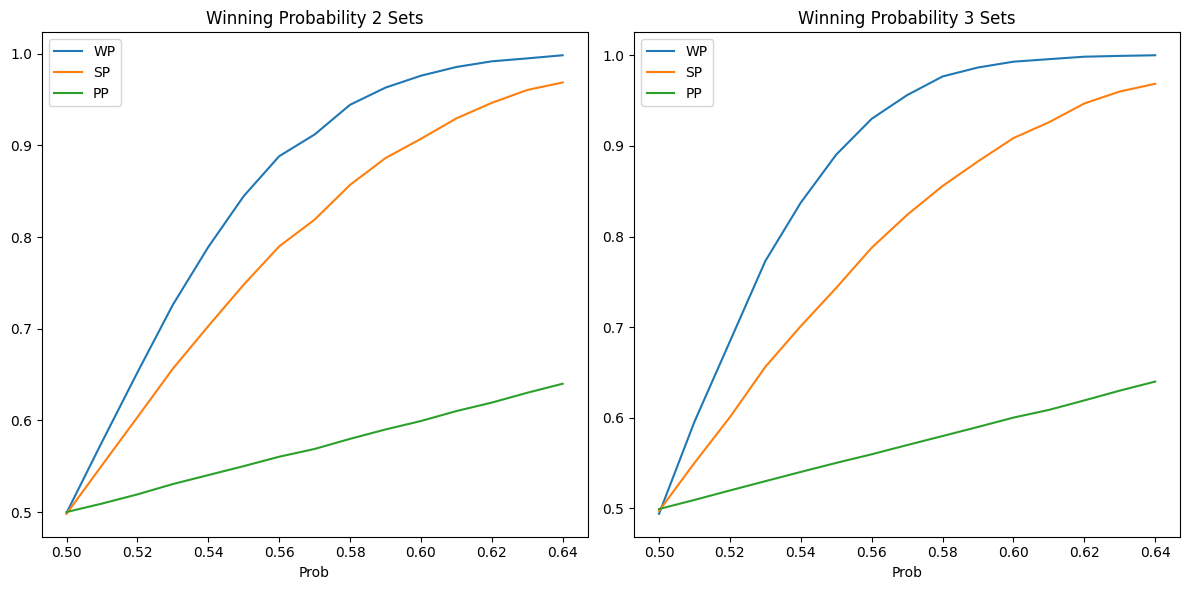

In [63]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

df_2sets = pd.DataFrame(result_2sets)
df_2sets.plot(x='Prob', y=['WP', 'SP', 'PP'], title='Winning Probability 2 Sets', ax=axs[0]);

df_3sets = pd.DataFrame(result_3sets)
df_3sets.plot(x='Prob', y=['WP', 'SP', 'PP'], title='Winning Probability 3 Sets', ax=axs[1]);

plt.tight_layout()

Find a function that fits the data in the interval shown. As it turns out, a sigmoid does.

[ 1.01178005 32.95453312  0.50135952]
[ 1.00764964 41.60114741  0.50127081]


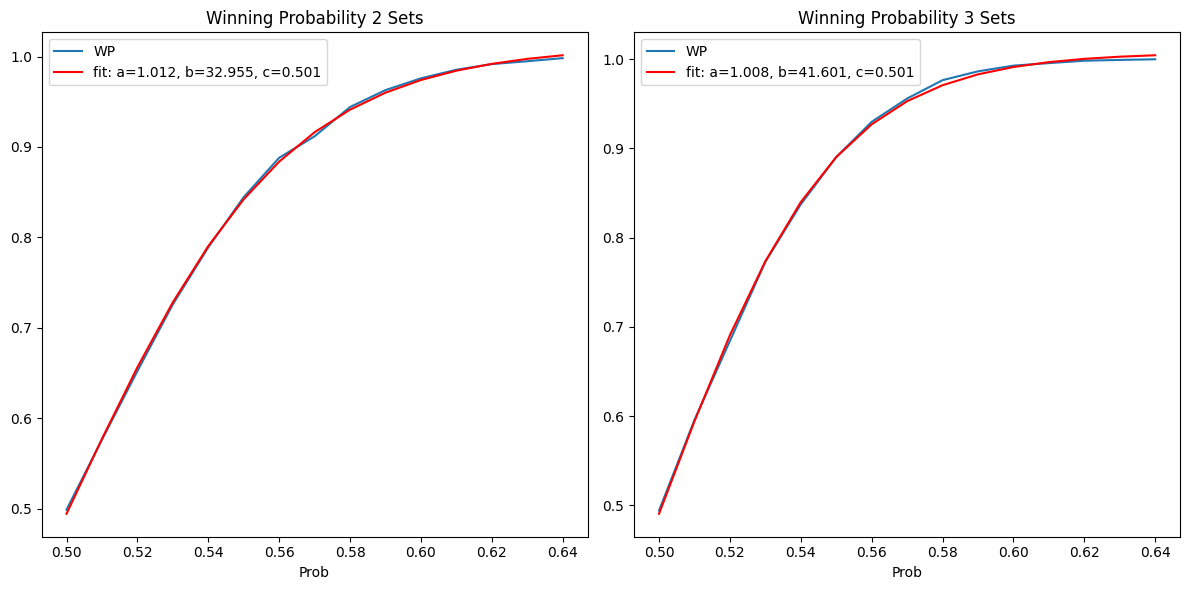

In [68]:
import numpy as np
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))

def fit_curve(df):
    popt, pcov = curve_fit(func, df['Prob'], df['WP'])
    return popt

popt_2sets = fit_curve(df_2sets)
popt_3sets = fit_curve(df_3sets)

print(popt_2sets)
print(popt_3sets)

# Plot the fitted curve and the original data
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

df_2sets.plot(x='Prob', y='WP', title='Winning Probability 2 Sets', ax=axs[0]);
axs[0].plot(df_2sets['Prob'], func(df_2sets['Prob'], *popt_2sets), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_2sets))

df_3sets.plot(x='Prob', y='WP', title='Winning Probability 3 Sets', ax=axs[1]);
axs[1].plot(df_3sets['Prob'], func(df_3sets['Prob'], *popt_3sets), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt_3sets))

# show labels
for ax in axs:
    ax.legend()

plt.tight_layout()

But in the more reasonable range, 0.50 - 0.55 a linear approximation works pretty good.

6.968857142857137 -2.9773666666666636
7.986571428571421 -3.480466666666663


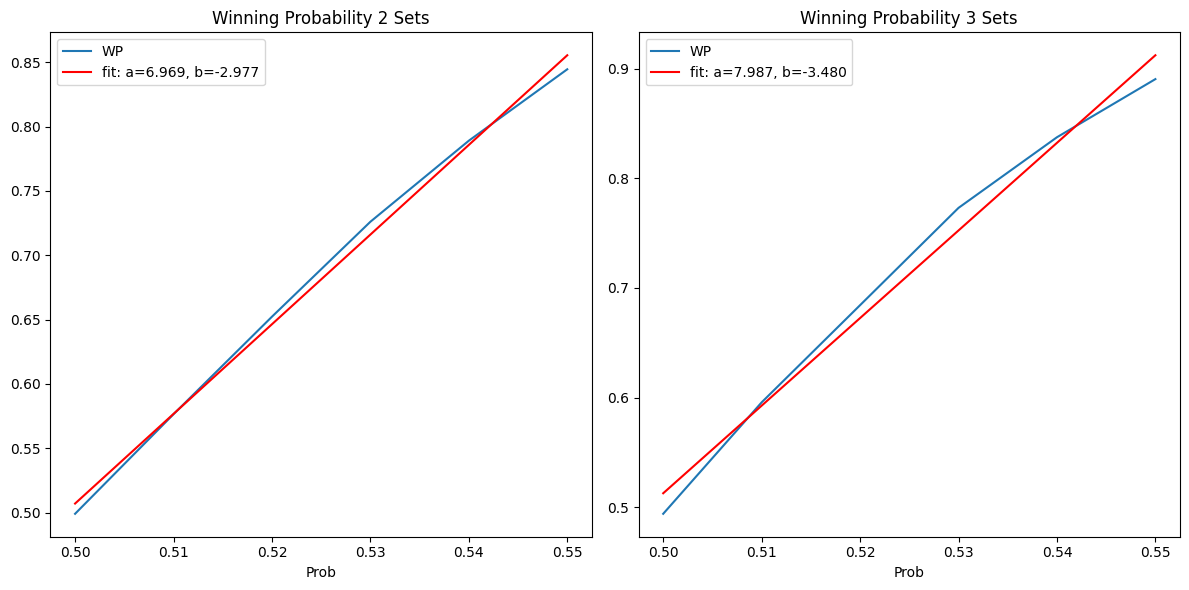

In [69]:
# Take just the rows with probability less than 0.56
df_2sets_low = df_2sets[df_2sets['Prob'] < 0.56]
df_3sets_low = df_3sets[df_3sets['Prob'] < 0.56]

# Do a linear fit on the data and plot the data and the fit
from scipy.stats import linregress

def fit_linear(df):
    slope, intercept, r_value, p_value, std_err = linregress(df['Prob'], df['WP'])
    return slope, intercept

slope_2sets, intercept_2sets = fit_linear(df_2sets_low)
slope_3sets, intercept_3sets = fit_linear(df_3sets_low)

print(slope_2sets, intercept_2sets)
print(slope_3sets, intercept_3sets)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

df_2sets_low.plot(x='Prob', y='WP', title='Winning Probability 2 Sets', ax=axs[0]);
axs[0].plot(df_2sets_low['Prob'], slope_2sets * df_2sets_low['Prob'] + intercept_2sets, 'r-', label='fit: a=%5.3f, b=%5.3f' % (slope_2sets, intercept_2sets))

df_3sets_low.plot(x='Prob', y='WP', title='Winning Probability 3 Sets', ax=axs[1]);
axs[1].plot(df_3sets_low['Prob'], slope_3sets * df_3sets_low['Prob'] + intercept_3sets, 'r-', label='fit: a=%5.3f, b=%5.3f' % (slope_3sets, intercept_3sets))

# show labels
for ax in axs:
    ax.legend()

plt.tight_layout()